In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')



In [33]:
# Helper functions

def p(vector : np.ndarray) -> np.ndarray:
    
    denominator = 1 + np.exp(-2*np.asarray(vector))
    
    return 1/denominator
    

def DKL(dist: np.ndarray) -> float:
    pd = np.asarray([1/4, 1/4, 1/4, 1/4, 0, 0, 0, 0])
    
    dkl = 0
    for i in range(4):
        if pd[i] > 0 and dist[i] > 0:
            dkl += pd[i] * np.log(pd[i]/dist[i])
        
        elif pd[i] == 0 and dist[i] > 0:
            dkl += 0
        
        else:
            dkl += np.infty
            
            
    return dkl


def DKLT(m: int) -> float:
    if m < 2**(2) - 1:
        dklt = 3 - np.floor(np.log2(m+1)) -(m+1)/(2**np.floor(np.log2(m+1)))
        dklt = np.log(2**dklt)
    else:
        dklt = 0
    
    return dklt
    

In [31]:
class RBM:
    def __init__(self, M, k):
        self.M = M
        self.k = k
        self.v = np.zeros((3,))
        self.h = np.zeros((M,))
        self.w = np.random.normal(0,1/np.sqrt(3),(M,3))
        self.tv = np.zeros((3,))
        self.th = np.zeros((M,))
        self.eta = 0.1
        
        
    def train(self, train_patterns):
#         print(train_patterns)
        for _ in range(1000): # 100 realisations
            # sample 20 different patterns
            dw = np.zeros(shape=self.w.shape)
            dth = np.zeros((self.M,))
            dtv = np.zeros((3,))
            
            for __ in range(20):
                idx = np.random.choice(len(train_patterns))
                # print(idx)
                mu = np.asarray(train_patterns[idx].copy())
#                 print(mu)
                self.v[:] = mu[:]
                v0 = np.asarray(mu)
                bh0 = self.w @ v0 - self.th
                
                probs = p(bh0)
                r = np.random.rand(self.M)
                self.h[:] = -1
                self.h[r < probs] = 1
                
                for t in range(self.k):
                    bv = np.dot(self.h,self.w) - self.tv
                    probs = p(bv)
                    r = np.random.rand(3)
                    self.v[:] = -1
                    self.v[r < probs] = 1
                    
                    bh = self.w @ self.v - self.th
                    probs = p(bh)
                    r = np.random.rand()
                    self.h[:] = -1
                    self.h[r < probs] = 1
                
                
                dw += self.eta   * (np.outer(np.tanh(bh0), v0) - np.outer(np.tanh(bh), self.v))
                dtv += -self.eta * (v0 - self.v)
                dth += -self.eta * (np.tanh(bh0) - np.tanh(bh))
            
            self.w += dw
            self.tv += dtv
            self.th += dth
            
    def compute_distribution(self, patterns):
        
        #feed 4000 patterns
        dist = np.zeros((len(patterns),))
        
        for _ in range(4000):
            idx = np.random.choice(len(patterns))
            mu = patterns[idx].copy()
            self.v = np.asarray(mu)
            # print(self.v)
            bh = self.w @ self.v - self.th
            probs = p(bh)
            r = np.random.rand(self.M)
            
            self.h[:] = -1
            self.h[r < probs] = 1
            
            for tt in range(500):
                bv = np.dot(self.h,self.w) - self.tv
                probs = p(bv)
                r = np.random.rand(3)
                self.v[:] = -1
                self.v[r < probs] = 1

                bh = self.w @ self.v - self.th
                probs = p(bh)
                r = np.random.rand(self.M)
                self.h[:] = -1
                self.h[r < probs] = 1
        
            
            # find what pattern we our visible neurons correspond to
            # print(self.v)
            for i, pattern in enumerate(patterns):
                
                if np.array_equal(pattern, self.v):
                    dist[i] += 1
                    #print(pattern)
        # print(patterns)
        return dist/np.sum(dist)

In [32]:
patterns = [[-1,-1,-1], [1,-1,1], [-1,1,1], [1,1,-1],
            [1,1,1], [-1,1,-1], [1,-1,-1], [-1,-1,1]]

M_vec = [1,2,4,8]
DKLs = []
for M in M_vec:

    rbm = RBM(M, 100)
    rbm.train([[-1,-1,-1], [1,-1,1], [-1,1,1], [1,1,-1]])
    print(f'M = {M : <2} trained')
    dist = rbm.compute_distribution(patterns)
    print(f'M = {M : <2} distribution found')
    print(dist)
    DKLs.append(DKL(dist))
    
print(DKLs)

M = 1  trained
M = 1  distribution found
[5.000e-04 6.720e-01 2.500e-04 2.050e-02 6.000e-02 0.000e+00 2.425e-01
 4.250e-03]
M = 2  trained
M = 2  distribution found
[0.304   0.227   0.012   0.08875 0.08525 0.04625 0.23225 0.0045 ]
M = 4  trained
M = 4  distribution found
[3.1200e-01 2.7200e-01 2.7300e-01 1.4225e-01 0.0000e+00 2.5000e-04
 0.0000e+00 5.0000e-04]
M = 8  trained
M = 8  distribution found
[2.4700e-01 2.4950e-01 2.7350e-01 2.2975e-01 2.5000e-04 0.0000e+00
 0.0000e+00 0.0000e+00]
[3.6586504966153273, 0.993283968604459, 0.04249513728802652, 0.002175759132900648]


In [46]:
import pickle as pkl
values = [rbm.eta, rbm.w, rbm.th, rbm.tv, rbm.k, DKLs]
# with open('values_M8.pkl', 'wb') as f:
#     pkl.dump(values, f)

In [34]:
DKLTs = []
for m in M_vec:
    DKLTs.append(DKLT(m))
print(DKLTs)
print(DKLT(2))

[0.6931471805599453, 0.3465735902799727, 0, 0]
0.3465735902799727


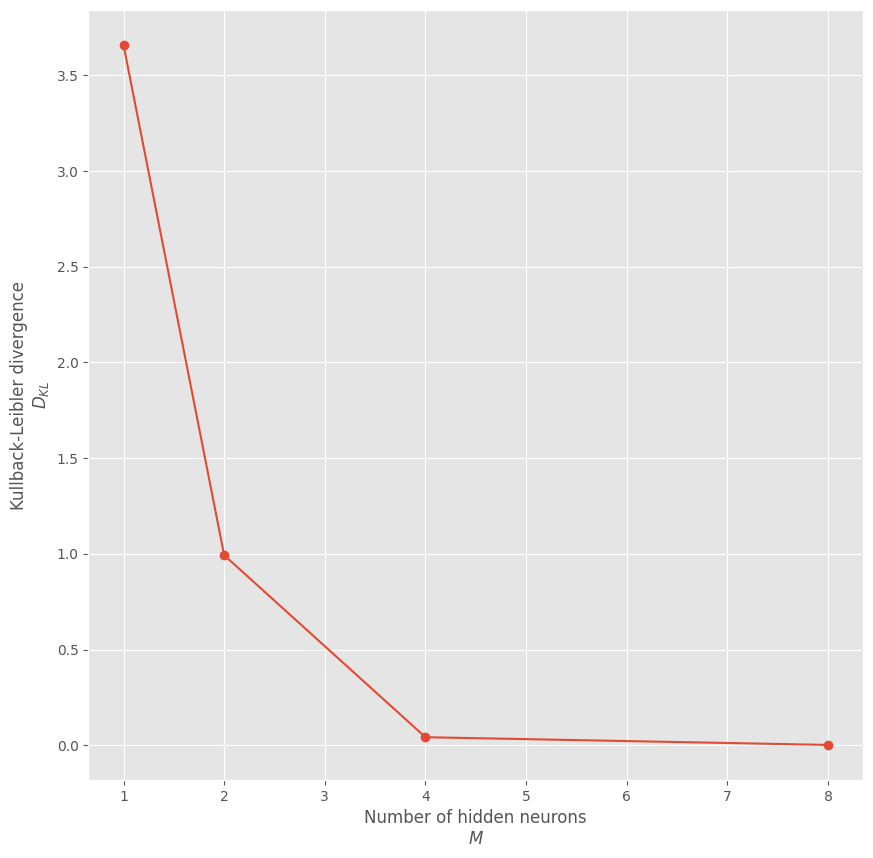

In [48]:
f = plt.figure(figsize=(10,10))
plt.plot(M_vec, DKLs, marker='o')
plt.xlabel('Number of hidden neurons\n$M$')
plt.ylabel('Kullback-Leibler divergence\n$D_{KL}$')
#[3.6586504966153273, 0.993283968604459, 0.04249513728802652, 0.002175759132900648]
plt.savefig('DKL_M.png')
plt.show()
